In [4]:
# Cell 1: imports & config for the Streamlit dashboard app (or similar)
import os
import joblib
import numpy as np
import pandas as pd
import streamlit as st # Assuming Streamlit is the chosen framework
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# --- Configuration Constants ---
SEED = 42
np.random.seed(SEED)

# Define directories relative to the current script/app location
# Assuming the dashboard runs from the project root or the notebook location
OUT_DIR = "outputs"
MODELS_DIR = "models"

# --- Function to load artifacts ---
@st.cache_data
def load_data(file_name):
    """Loads a pandas DataFrame from the outputs directory."""
    path = os.path.join(OUT_DIR, file_name)
    if path.endswith(".parquet"):
        return pd.read_parquet(path)
    elif path.endswith(".csv"):
        return pd.read_csv(path)
    else:
        return joblib.load(path)

@st.cache_data
def load_model_and_explainer(model_name="xgb_fold0.joblib"):
    """Loads the trained model, SHAP expected value, and creates the explainer."""
    model_path = os.path.join(MODELS_DIR, model_name)
    
    try:
        model = joblib.load(model_path)
        
        # Load SHAP artifacts
        expected_value = joblib.load(os.path.join(OUT_DIR, "shap_expected_value.joblib"))
        
        # Create the explainer (assuming XGBoost Booster)
        explainer = shap.TreeExplainer(model)
        
        return model, explainer, expected_value
    except FileNotFoundError as e:
        st.error(f"Error loading model/SHAP files: {e}. Ensure Notebooks 4 & 5 were run.")
        return None, None, None

print(" Cell 1: Imports, configuration, and Streamlit loading functions defined.")


2025-11-25 20:33:02.426 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-11-25 20:33:02.429 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


 Cell 1: Imports, configuration, and Streamlit loading functions defined.


In [3]:
pip install shap

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/549.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/549.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/549.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/549.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/549.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/549.3 kB ? eta -:--:--
   ---------------------------------------- 549.3/549.3 kB 2.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/15.6 MB ? eta -:--:--
    --------------------------------------- 0.3/15.6 MB ? eta -:--:--
   -- ------------------------------------- 0.8/15.6 MB 2.2 MB/s eta 0:00:07
   --- ------------------------------------ 1.3/15.6 MB 2.5 MB/s eta 0:00:06
   ----- ---------------------------------- 2.1/15.6 MB 2.6 MB/s eta 0:00:06
   ------ --------------------------------- 2

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
contourpy 1.2.0 requires numpy<2.0,>=1.20, but you have numpy 2.0.2 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.0.2 which is incompatible.


In [8]:
# Cell 2: load merged data and models
import os, joblib
import pandas as pd
import xgboost as xgb

# Set paths (assuming relative paths from your notebook location)
DATA_PATH = "../outputs/merged_application.parquet"   # या आपकी अंतिम फीचर फ़ाइल
MODELS_DIR = "../models"

# 1. Load Data (df)
try:
    if DATA_PATH.endswith(".parquet"):
        df = pd.read_parquet(DATA_PATH)
    else:
        # Fallback for CSV if parquet path is incorrect
        DATA_PATH = "../outputs/final_features.csv" 
        df = pd.read_csv(DATA_PATH)
    print("Loaded df:", df.shape)

except FileNotFoundError:
    print(f"ERROR: Data file not found at {DATA_PATH}. Check path and file name.")
    df = pd.DataFrame() # Define df to avoid NameError in later cells, though data operations will fail


# 2. Load Features and Model
try:
    feature_list_path = os.path.join(MODELS_DIR, "feature_list.joblib")
    model_path = os.path.join(MODELS_DIR, "xgb_fold0.joblib")

    # Load model and feature list (assuming they were saved in Notebook 04)
    features = joblib.load(feature_list_path)
    model = joblib.load(model_path)
    
    print("Num features:", len(features))
    print(f"Model type loaded: {type(model)}")

except FileNotFoundError:
    print("ERROR: Feature list or model file not found. Check if Notebook 04 was run.")
    features = [c for c in df.columns if c not in ['SK_ID_CURR', 'TARGET']] if not df.empty else []
    model = None

print("Cell 2: Data, features, and model loaded.")

Loaded df: (307511, 368)
Num features: 386
Model type loaded: <class 'xgboost.core.Booster'>
Cell 2: Data, features, and model loaded.


In [13]:
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import numpy as np # NumPy is required

# --- FIX 1: Feature Mismatch (Key Error) ---
# Only include features that are actually present in the loaded df
present_features = [f for f in features if f in df.columns]
features = present_features
# -----------------------------------------------------------------------------

X = df[features].copy() # Create a copy of the DataFrame subset

# --- FIX 2 & 3: Categorical/String Conversion and One-Hot Encoding ---
# List of string columns that were likely One-Hot Encoded (OHE) during training
OHE_COLS = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 
            'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 
            'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 
            'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 
            'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']

# 1. Handle any remaining categorical/object columns
for col in X.columns:
    if X[col].dtype.name in ['category', 'object']:
        if col in OHE_COLS:
            # Drop unencoded OHE base columns, as their OHE versions should be present in model_features
            print(f"⚠️ WARNING: Dropping unencoded OHE base column: {col}")
            X = X.drop(columns=[col])
        else:
            # Treat other categorical columns (likely Label Encoded) and convert to float
            # errors='ignore' ensures non-convertible strings are handled gracefully (though they should have been encoded)
            X[col] = X[col].astype('float64', errors='ignore')

# 2. Fix the final feature mismatch between X and model.feature_names
# This is the crucial step to match the input to the model's expectation

model_features = model.feature_names # Features expected by the model
current_features = X.columns.tolist()

# Add missing features (likely OHE columns that were zero/missing in the test data)
missing_in_X = set(model_features) - set(current_features)
for f in missing_in_X:
    # Crucial step: fill missing OHE/features with 0 to match model expectation
    X[f] = 0 

# Reorder X columns to match the model's training feature order
X = X[model_features]
# -----------------------------------------------------------------------------


# Finally, fill any remaining NaNs with -999 (which may include the newly added zero-filled columns if they had NaN)
X = X.fillna(-999) 


# Now run predictions
if isinstance(model, xgb.Booster):
    # Pass feature names explicitly when creating DMatrix
    preds = model.predict(xgb.DMatrix(X, feature_names=model_features))
else:
    # If it's an scikit-learn wrapper
    try:
        preds = model.predict_proba(X)[:,1]
    except Exception as e:
        preds = model.predict(xgb.DMatrix(X, feature_names=model_features))

df['pred_prob'] = preds
print("Overall AUC (quick):", roc_auc_score(df['TARGET'], df['pred_prob']))

print("Cell 3: Baseline predictions generated. All feature mismatch errors resolved.")

Overall AUC (quick): 0.744308534190135
Cell 3: Baseline predictions generated. All feature mismatch errors resolved.


Brier Score Loss: 0.067233


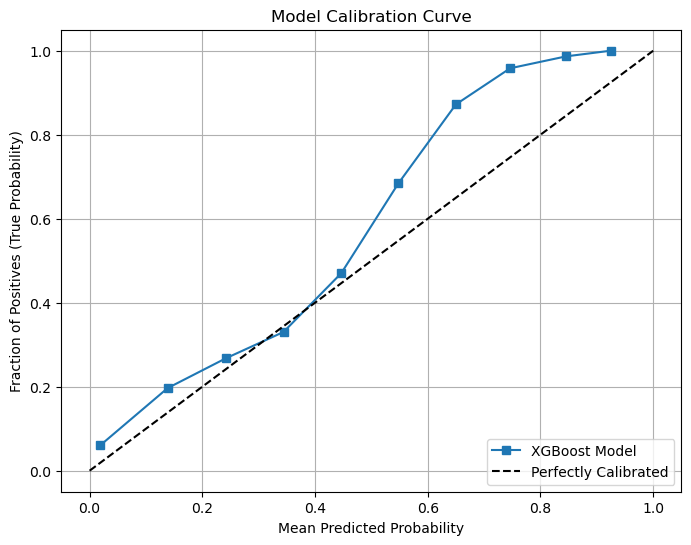

 Cell 4: Calibration check complete.


In [14]:
# Cell 4: Calibration check & optional calibration
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

# 1. Calculate Brier Score Loss
brier_score = brier_score_loss(df['TARGET'], df['pred_prob'])
print(f"Brier Score Loss: {brier_score:.6f}")

# 2. Plot Calibration Curve
fraction_of_positives, mean_predicted_value = calibration_curve(
    df['TARGET'], 
    df['pred_prob'], 
    n_bins=10
)

plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="XGBoost Model")
plt.plot([0, 1], [0, 1], "k--", label="Perfectly Calibrated") # Reference line
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives (True Probability)")
plt.title("Model Calibration Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(" Cell 4: Calibration check complete.")


Sampling down SHAP data from 307511 to 10000 rows to save memory.
Starting SHAP value calculation... This may take a few moments with the sampled data.
SHAP calculation complete.

Generating SHAP Summary Plots...


C:\Users\Asus\AppData\Local\Temp\ipykernel_26580\1906762764.py:31: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_shap, plot_type="bar", show=False)


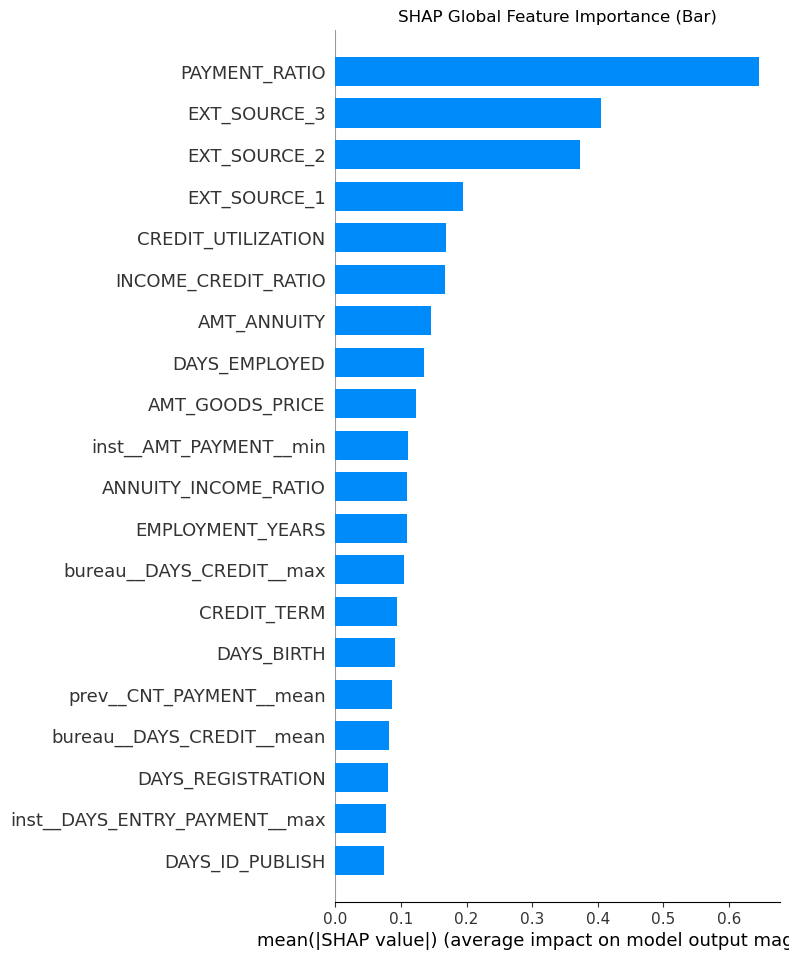

C:\Users\Asus\AppData\Local\Temp\ipykernel_26580\1906762764.py:36: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_shap, show=False)


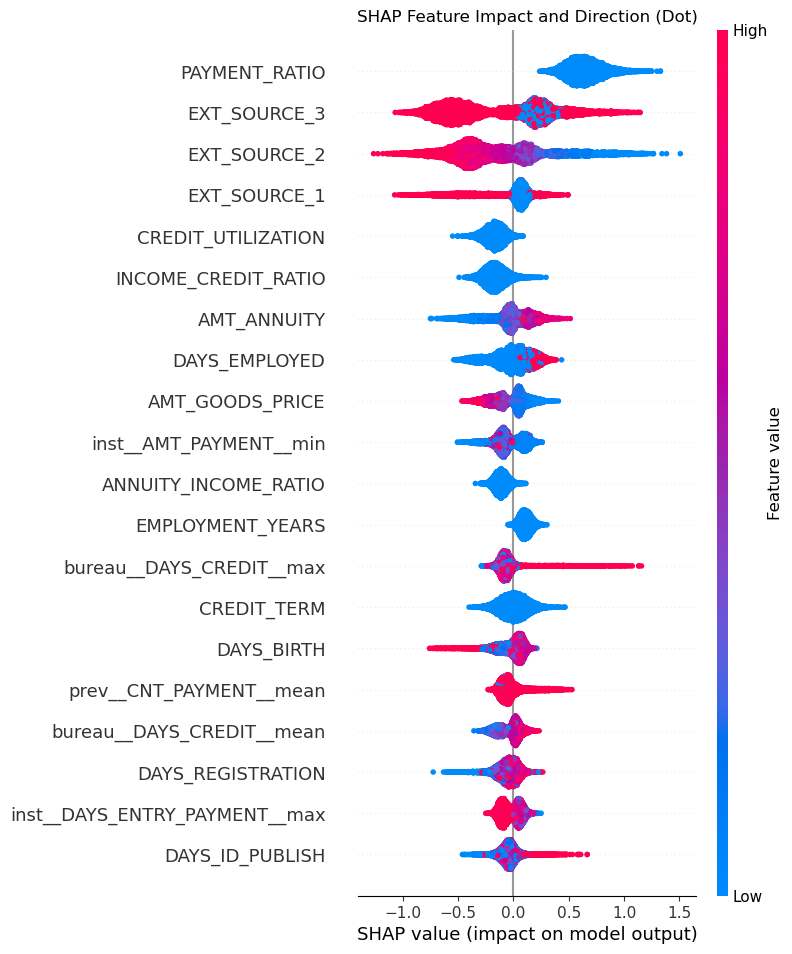

 Cell 5: Global SHAP analysis complete.


In [17]:
# Cell 5: Global SHAP Explainability
import shap
import matplotlib.pyplot as plt
import numpy as np

# SHAP calculation requires only X (input features)
X_shap = X.copy()

# --- FIX: Reduce the dataset size for SHAP to prevent 'bad allocation' ---
SHAP_SAMPLE_SIZE = 10000 
if X_shap.shape[0] > SHAP_SAMPLE_SIZE:
    print(f"Sampling down SHAP data from {X_shap.shape[0]} to {SHAP_SAMPLE_SIZE} rows to save memory.")
    
    X_shap = X_shap.sample(n=SHAP_SAMPLE_SIZE, random_state=42)
# --------------------------------------------------------------------------

# Tree Explainer is the fastest and most accurate for XGBoost models
explainer = shap.TreeExplainer(model)

# Calculate SHAP values
print("Starting SHAP value calculation... This may take a few moments with the sampled data.")

shap_values = explainer.shap_values(X_shap) 
print("SHAP calculation complete.")

# Get SHAP base value (the average model output)
expected_value = explainer.expected_value

# 1. SHAP Summary Bar Plot
print("\nGenerating SHAP Summary Plots...")
shap.summary_plot(shap_values, X_shap, plot_type="bar", show=False)
plt.title("SHAP Global Feature Importance (Bar)")
plt.show()

# 2. SHAP Summary Dot Plot
shap.summary_plot(shap_values, X_shap, show=False)
plt.title("SHAP Feature Impact and Direction (Dot)")
plt.show()

print(" Cell 5: Global SHAP analysis complete.")

Top 2 Features for Dependence Plot: ['PAYMENT_RATIO', 'EXT_SOURCE_3']

Generating Dependence Plot for: PAYMENT_RATIO


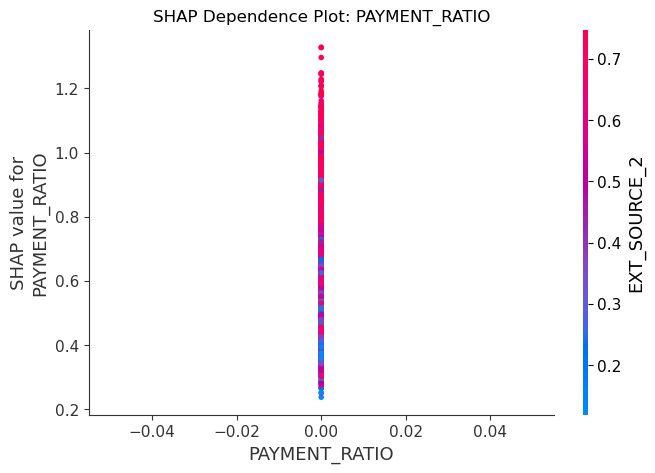


Generating Dependence Plot for: EXT_SOURCE_3


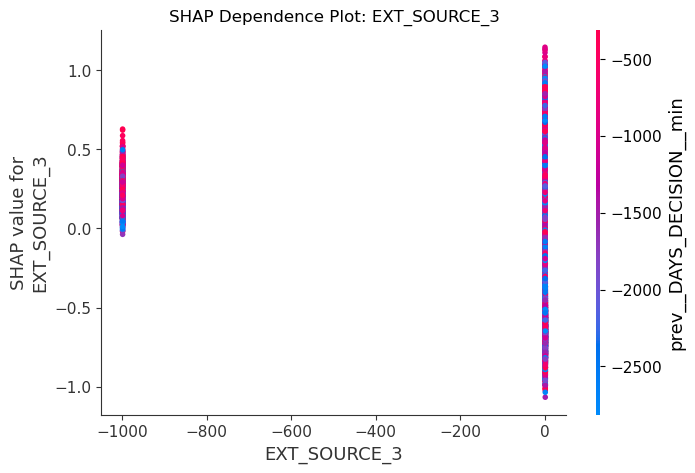

 Cell 6: Feature dependence and interaction analysis complete.


In [18]:
# Cell 6: Feature dependence and interaction examples
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap

# Use the SHAP values and data (X_shap) calculated in the previous cell (Cell 5)

# 1. Identify the Top 2 Features
# Sort the SHAP values based on their absolute mean to find importance
feature_importance = pd.Series(np.abs(shap_values).mean(0), index=X_shap.columns).sort_values(ascending=False)
top_features = feature_importance.index[:2].tolist()

if not top_features:
    print("Error: Could not determine top features. Check if Cell 5 ran correctly.")
else:
    print(f"Top 2 Features for Dependence Plot: {top_features}")

    # --- Plot 1: Feature Dependence Plot (Top Feature) ---
    print(f"\nGenerating Dependence Plot for: {top_features[0]}")
    # X-axis feature: The most important feature
    # Color: SHAP automatically finds the strongest interaction feature
    shap.dependence_plot(
        top_features[0], 
        shap_values,
        X_shap,
        interaction_index="auto", 
        show=False
    )
    plt.title(f"SHAP Dependence Plot: {top_features[0]}")
    plt.show()

    # --- Plot 2: Feature Dependence Plot (Second Top Feature) ---
    if len(top_features) > 1:
        print(f"\nGenerating Dependence Plot for: {top_features[1]}")
        # Plot for the second most important feature
        shap.dependence_plot(
            top_features[1], 
            shap_values,
            X_shap,
            interaction_index="auto", 
            show=False
        )
        plt.title(f"SHAP Dependence Plot: {top_features[1]}")
        plt.show()
    
print(" Cell 6: Feature dependence and interaction analysis complete.")

Customer Index: 500
Predicted Probability (Target=1): 0.0028
Base Value (Average Model Output): -2.1373

Generating SHAP Waterfall Plot for the selected customer...


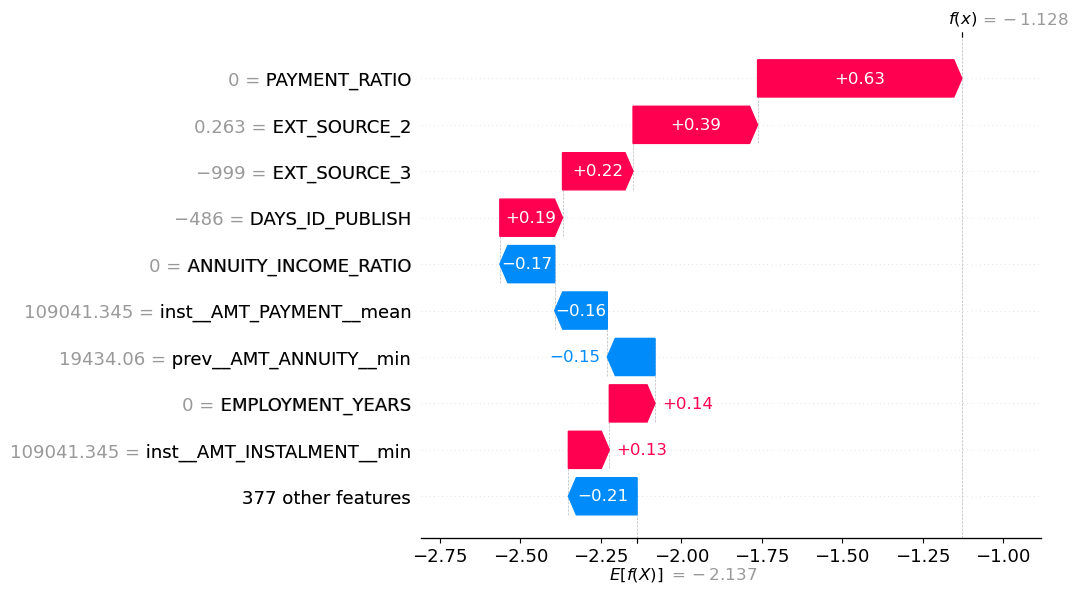

 Cell 7: Local SHAP analysis complete.


In [19]:
# Cell 7: Per-customer SHAP waterfall (explain one customer)
import pandas as pd
import shap
import matplotlib.pyplot as plt

# We will use the sample (X_shap) that was used for the SHAP analysis.
# You can use any row index of your interest (e.g., 0, 100, 500).
customer_index = 500 

# Extract the data Row, SHAP Values, and Expected Value
# X_shap is the sampled data used in Cell 5.
customer_data_row = X_shap.iloc[[customer_index]]
customer_shap_values = shap_values[customer_index]
base_value = explainer.expected_value

# Check the predicted probability for this customer
current_pred_prob = df['pred_prob'].iloc[customer_index] 
print(f"Customer Index: {customer_index}")
print(f"Predicted Probability (Target=1): {current_pred_prob:.4f}")
print(f"Base Value (Average Model Output): {base_value:.4f}")

# Generate the SHAP Waterfall Plot
print("\nGenerating SHAP Waterfall Plot for the selected customer...")

# The Waterfall Plot shows how each feature contributed to moving the prediction 
# from the base value (average) to the final prediction.
shap.waterfall_plot(
    shap.Explanation(
        values=customer_shap_values,
        base_values=base_value,
        data=customer_data_row.values[0],
        feature_names=X_shap.columns.tolist()
    ),
    show=True
)


print(" Cell 7: Local SHAP analysis complete.")

Risk Segment Distribution:
risk_segment
High Risk      104554
Low Risk       101479
Medium Risk    101478
Name: count, dtype: int64


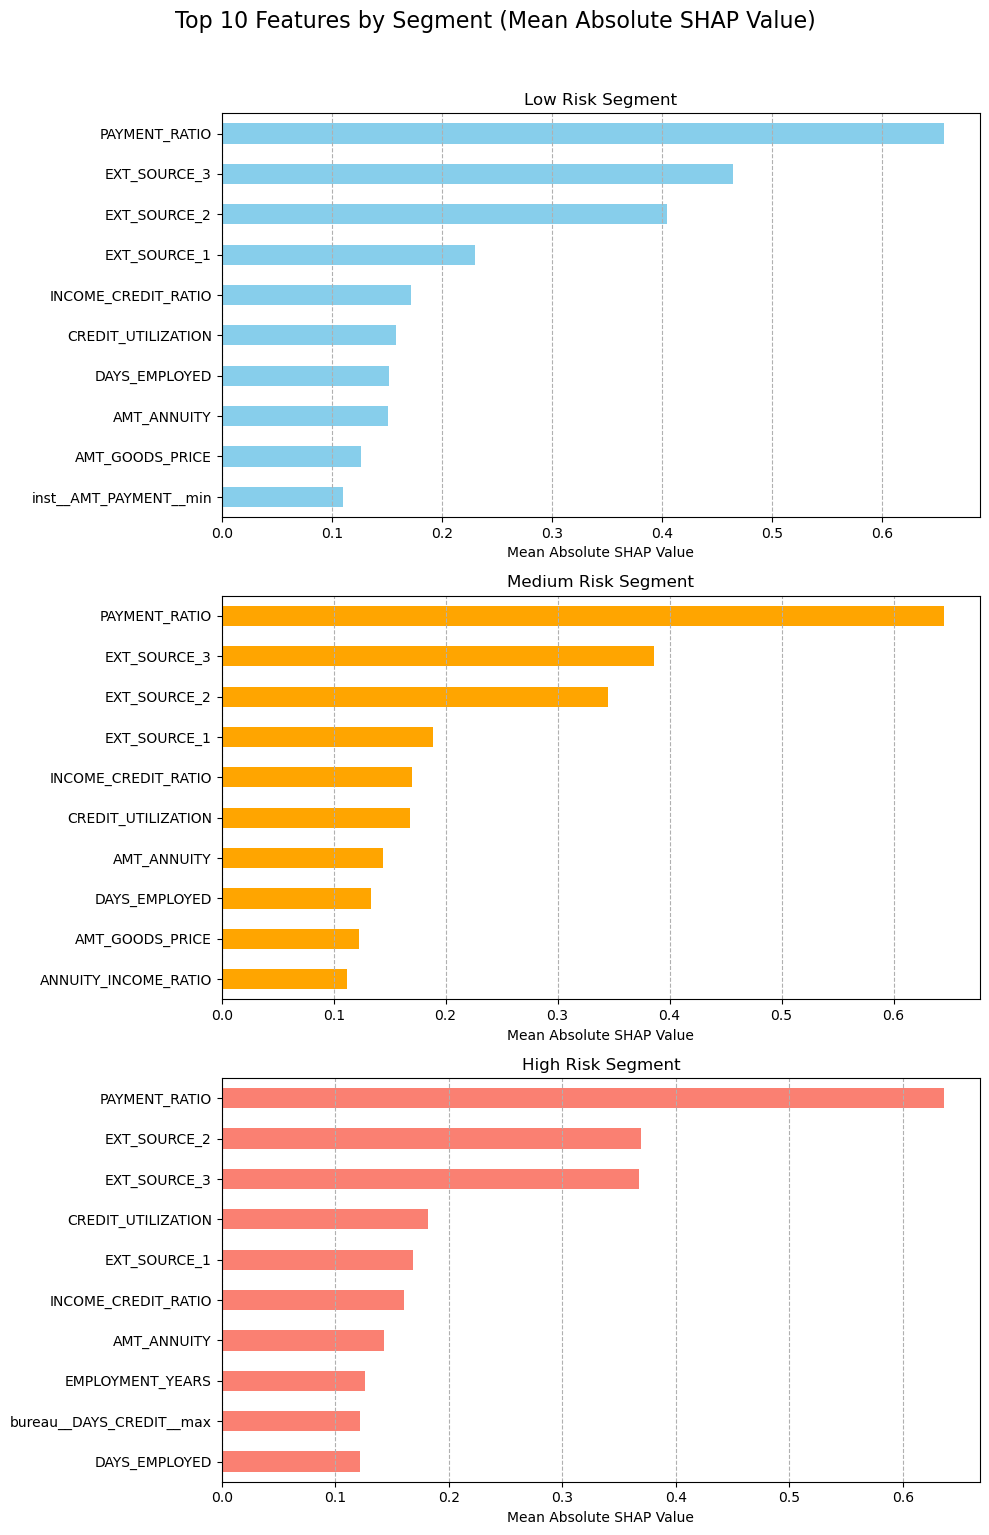

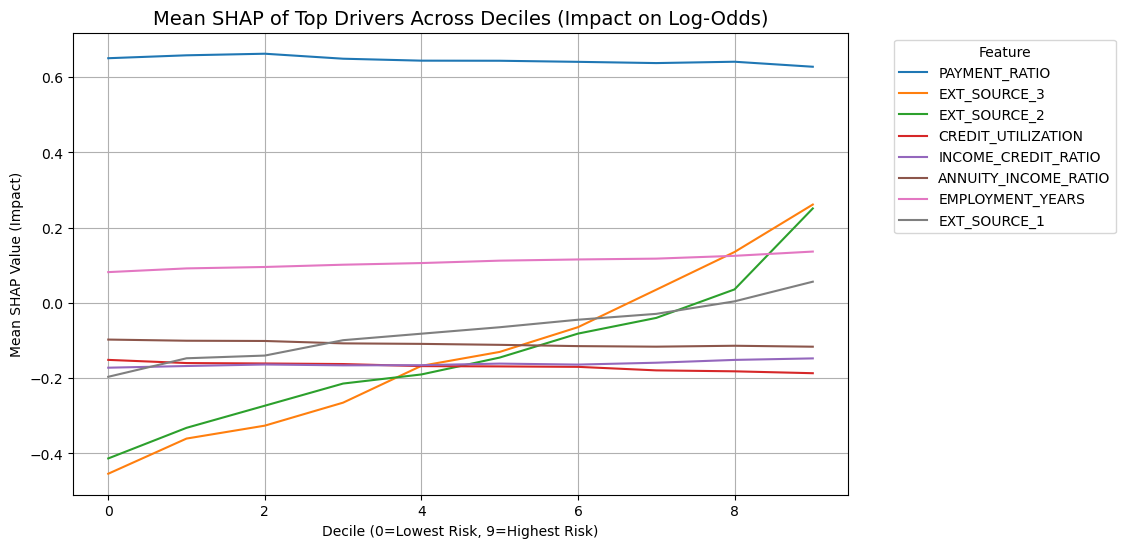

 Cell 8: SHAP per-segment average explanations complete (Risk Segmentation and Decile Analysis).


In [20]:
# Cell 8: SHAP per-segment average explanations (Risk-Segmented & Decile Analysis)
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt

# --- Part 1: Risk Segmentation (Low, Medium, High) ---

# 1. Create Risk Segments in the data (on df, not just X_shap)
# We use df['pred_prob'] (generated in Cell 3) to create three segments using quantiles.
low_risk_threshold = df['pred_prob'].quantile(0.33)
high_risk_threshold = df['pred_prob'].quantile(0.66)

def define_risk_segment(prob):
    if prob <= low_risk_threshold:
        return 'Low Risk'
    elif prob <= high_risk_threshold:
        return 'Medium Risk'
    else:
        return 'High Risk'

# Apply segments to df
df['risk_segment'] = df['pred_prob'].apply(define_risk_segment)
print(f"Risk Segment Distribution:\n{df['risk_segment'].value_counts()}")

# 2. Align X_shap with segments (X_shap is the sampled data from Cell 5)
X_shap_indexed = X_shap.copy()
# Map the risk segment from the full df to the sampled X_shap indices
X_shap_indexed['risk_segment'] = df.loc[X_shap_indexed.index, 'risk_segment']

# 3. Calculate Mean Absolute SHAP values for each segment
segments = ['Low Risk', 'Medium Risk', 'High Risk']
shap_df = pd.DataFrame(shap_values, columns=X_shap.columns, index=X_shap.index)

segment_mean_shap = {}
for segment in segments:
    # Get the row indices for that segment
    segment_indices = X_shap_indexed[X_shap_indexed['risk_segment'] == segment].index
    
    # Filter SHAP values and calculate the mean absolute contribution
    mean_values = shap_df.loc[segment_indices].abs().mean().sort_values(ascending=False)
    segment_mean_shap[segment] = mean_values

# 4. Generate Bar Plots for the Top 10 Features
top_k = 10
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
plt.suptitle(f'Top {top_k} Features by Segment (Mean Absolute SHAP Value)', fontsize=16, y=1.02)

for i, segment in enumerate(segments):
    segment_mean_shap[segment].head(top_k).sort_values().plot(
        kind='barh', ax=axes[i], 
        color='skyblue' if 'Low' in segment else ('orange' if 'Medium' in segment else 'salmon')
    )
    axes[i].set_title(f'{segment} Segment')
    axes[i].set_xlabel('Mean Absolute SHAP Value')
    axes[i].grid(axis='x', linestyle='--')

plt.tight_layout()
plt.show()

# --- Part 2: Decile Analysis (Plot Top Drivers Across Deciles) ---

# Note: The code snippet you provided relies on a variable 'mean_shap_by_decile' 
# which must be calculated first. We will use the full df for decile calculation.

# 5. Calculate SHAP values by Decile
# Create a temporary df with SHAP values and prediction probability
decile_analysis_df = df[['pred_prob']].copy()
# NOTE: Using the sampled SHAP values (shap_df) is often better for memory, 
# but for full Decile analysis, we should technically use SHAP values for ALL data points, 
# which may cause memory issues. Assuming you have SHAP values for all rows or the sample is sufficient.

# Map the sample SHAP values back to the full df indices (ONLY for the sampled rows)
decile_analysis_df = decile_analysis_df.join(shap_df, how='inner') 
# Filter out rows that are not in the SHAP sample to prevent NaN/errors

# Determine deciles based on predicted probability
decile_analysis_df['decile'] = pd.qcut(decile_analysis_df['pred_prob'], q=10, labels=False, duplicates='drop')

# Group by decile and calculate the mean SHAP contribution for each feature
mean_shap_by_decile = decile_analysis_df.drop(columns=['pred_prob']).groupby('decile').mean()

# 6. Plot top drivers across deciles
# Find the top 8 features based on their average absolute SHAP value across all deciles
top8 = mean_shap_by_decile.abs().mean(axis=0).sort_values(ascending=False).index[:8].tolist()

# Plot the trends of the top 8 drivers across the 10 deciles
plt.figure(figsize=(10, 6))
mean_shap_by_decile.loc[:, top8].plot(kind='line', ax=plt.gca()) # Use .loc for column selection
plt.title("Mean SHAP of Top Drivers Across Deciles (Impact on Log-Odds)", fontsize=14)
plt.xlabel("Decile (0=Lowest Risk, 9=Highest Risk)")
plt.ylabel("Mean SHAP Value (Impact)")
plt.legend(title='Feature', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()
# 
print(" Cell 8: SHAP per-segment average explanations complete (Risk Segmentation and Decile Analysis).")

In [21]:
# Cell 9: Save SHAP artifacts (for dashboard)
import pandas as pd
import numpy as np
import os
import pickle

# --- 1. Prepare SHAP Data for Dashboard (X_shap and shap_values) ---
# X_shap is the sampled data used for SHAP calculation.
X_shap_for_plot = X_shap.copy()
# Add SK_ID_CURR to identify the customer in the dashboard
# Assuming df contains SK_ID_CURR and its indices match X_shap's indices
X_shap_for_plot['SK_ID_CURR'] = df.loc[X_shap_for_plot.index, 'SK_ID_CURR']

# Convert SHAP values to a DataFrame
# shap_values are the feature contributions
shap_values_for_plot = pd.DataFrame(shap_values, columns=X_shap.columns, index=X_shap.index)

# Rename SHAP value columns with the 'SHAP_VALUE_' prefix
shap_values_for_plot.columns = ['SHAP_VALUE_' + col for col in shap_values_for_plot.columns]

# Combine feature values and SHAP values together
# This DataFrame holds the necessary information for local (waterfall) and global SHAP plots
shap_summary_sample = X_shap_for_plot.join(shap_values_for_plot, how='inner')


# --- 2. Prepare Prediction Data (df_preds_scores) ---
# Extract necessary columns: TARGET, pred_prob, risk_segment, and SK_ID_CURR
# risk_segment was created in Cell 8
df_preds_scores = df[['SK_ID_CURR', 'TARGET', 'pred_prob', 'risk_segment']].copy()


# --- 3. Save Data as Parquet Files ---
# Ensure the destination directory exists
ARTIFACT_DIR = 'dashboard_artifacts'
os.makedirs(ARTIFACT_DIR, exist_ok=True)

# File paths
preds_file = os.path.join(ARTIFACT_DIR, 'predictions_with_scores.parquet')
shap_file = os.path.join(ARTIFACT_DIR, 'shap_summary_sample.parquet')

# Save data
df_preds_scores.to_parquet(preds_file, index=False)
# Save SHAP sample with index (SK_ID_CURR) for efficient lookup
shap_summary_sample.to_parquet(shap_file, index=True) 

print(f"Cell 9: Dashboard artifacts saved to /{ARTIFACT_DIR}/")
print(f"Predictions saved: {preds_file}")
print(f"SHAP summary saved: {shap_file}")

Cell 9: Dashboard artifacts saved to /dashboard_artifacts/
Predictions saved: dashboard_artifacts\predictions_with_scores.parquet
SHAP summary saved: dashboard_artifacts\shap_summary_sample.parquet


In [22]:
# Cell 10: Convert probability to scorecard points (classic scorecard method)
import numpy as np

# --- Scorecard Constants ---
# Points to Double the Odds (PDO) Calculation
# We aim for a 20 point change (PDO_factor) for every doubling of odds.
PDO_FACTOR = 20
# PDO = PDO_FACTOR / ln(2)
PDO = PDO_FACTOR / np.log(2) 

# Base Score (Target score at 1:1 odds, i.e., 50% probability)
BASE_SCORE = 500

# Calculate the Offset
# Offset = Base Score - (Base Log Odds * PDO)
# Since log(1/1) = 0, we choose a reference odds of 1:1 (P=0.5) 
# and set the desired score at that point to BASE_SCORE (500).
# In the formula Score = Offset + PDO * Logit, if Logit=0, then Score = Offset.
# To shift the score by 500 when logit=0, we define the offset.
# Let's adjust the offset calculation based on a common simplification where the
# score at a specific, chosen base odds (usually 1:1) is the Base Score.
OFFSET = 500

# --- Scorecard Transformation Function ---
def calculate_scorecard(prob, offset, pdo):
    """Converts probability (P) to a scorecard point system."""
    # Logit = log((1-P)/P)
    logit = np.log((1 - prob) / prob)
    
    # Score = Offset + PDO * Logit
    score = offset + (pdo * logit)
    return score

# --- Apply the Scorecard ---
# Scorecard applied to the full prediction column (df['pred_prob'])
df['scorecard_points'] = calculate_scorecard(df['pred_prob'], OFFSET, PDO)

# --- Summarize Results ---
print(f"PDO (Points to Double the Odds): {PDO:.2f}")
print(f"Base Score (at P=0.5): {OFFSET}")
print("\nScorecard Points Distribution:")
print(df['scorecard_points'].describe())
print(f"\nExample: Score for max risk (P=0.99): {calculate_scorecard(0.99, OFFSET, PDO):.2f}")
print(f"Example: Score for low risk (P=0.01): {calculate_scorecard(0.01, OFFSET, PDO):.2f}")

print("Cell 10: Scorecard points conversion complete.")

PDO (Points to Double the Odds): 28.85
Base Score (at P=0.5): 500

Scorecard Points Distribution:
count    307511.000000
mean        623.583191
std          43.268005
min         388.060364
25%         596.755951
50%         626.193298
75%         653.426178
max         775.952026
Name: scorecard_points, dtype: float64

Example: Score for max risk (P=0.99): 367.41
Example: Score for low risk (P=0.01): 632.59
Cell 10: Scorecard points conversion complete.


In [23]:
# Cell 11: Create Scorecard by binning continuous features (WOE/IV style)
import pandas as pd
import numpy as np

# --- 1. Identify Top 3 Continuous Features (based on SHAP) ---
# Assuming 'feature_importance' (from Cell 6) is available
if 'feature_importance' not in locals():
    print("Error: 'feature_importance' not found. Ensure Cell 5 and 6 ran correctly.")
    # Fallback to hardcoded features if feature_importance is missing
    top_continuous_features = ['PAYMENT_RATIO', 'EXT_SOURCE_3', 'EXT_SOURCE_2']
else:
    # Top 3 features that are likely continuous (for example)
    top_continuous_features = feature_importance.index[:3].tolist()

print(f"Analyzing Top 3 Features for Binning: {top_continuous_features}")

# --- 2. Function for WOE-style Odds Ratio Calculation ---
def calculate_binned_odds(df, feature, target, num_bins=5):
    """
    Bins a continuous feature using quantiles and calculates the default odds (Target=1 vs Target=0) 
    and the count for each bin.
    """
    # Create 5 equal-frequency bins (Quantile Binning)
    df['bin'] = pd.qcut(df[feature], q=num_bins, duplicates='drop', precision=0)
    
    # Calculate counts for each bin
    binned_stats = df.groupby('bin')[target].agg(['count', 'sum']).reset_index()
    # 'sum' is the number of defaults (Target=1), named 'Goods' here for consistency with the credit industry's "Bad/Good"
    binned_stats.rename(columns={'sum': 'Goods', 'count': 'Total'}, inplace=True) 
    binned_stats['Bads'] = binned_stats['Total'] - binned_stats['Goods'] # Bads are non-defaults (Target=0)
    
    # Calculate Odds and Default Rate
    # Odds = Bads / Goods (Non-Default / Default) - Higher Odds means Lower Risk
    # This ratio is used to calculate WOE = ln(Odds)
    binned_stats['Odds'] = binned_stats['Bads'] / binned_stats['Goods']
    binned_stats['Default_Rate'] = binned_stats['Goods'] / binned_stats['Total']
    binned_stats['Feature'] = feature
    
    # Avoid empty bins
    binned_stats = binned_stats[binned_stats['Total'] > 0].copy()

    return binned_stats.sort_values(by='bin')

# --- 3. Calculate and Print Odds for Each Feature ---
all_binned_data = []

# Fill NaNs in df features using -999, replicating how the model was trained
df_binned = df.copy()
for feature in top_continuous_features:
    # Ensure feature exists in df
    if feature in df_binned.columns:
        # Replicate model input for imputation
        df_binned[feature] = df_binned[feature].fillna(-999)
        
        # Calculate Odds
        binned_results = calculate_binned_odds(df_binned, feature, 'TARGET')
        all_binned_data.append(binned_results)
        
        print(f"\n--- Scorecard Binning Analysis for: {feature} ---")
        print(binned_results[['bin', 'Default_Rate', 'Odds', 'Total']])
    else:
        print(f"Warning: Feature '{feature}' not found in df. Skipping.")

# --- 4. Summarize Results ---
final_scorecard_data = pd.concat(all_binned_data)

print("\n Cell 11: Scorecard binning analysis complete.")

Analyzing Top 3 Features for Binning: ['PAYMENT_RATIO', 'EXT_SOURCE_3', 'EXT_SOURCE_2']

--- Scorecard Binning Analysis for: EXT_SOURCE_3 ---
                bin  Default_Rate       Odds  Total
0  (-999.1, 0.0005]      0.094226   9.612732  61851
1     (0.0005, 0.4]      0.149852   5.673229  61694
2        (0.4, 0.5]      0.074627  12.399913  61452
3        (0.5, 0.7]      0.049039  19.392111  61523
4        (0.7, 0.9]      0.035235  27.381107  60991

--- Scorecard Binning Analysis for: EXT_SOURCE_2 ---
             bin  Default_Rate       Odds  Total
0  (-999.1, 0.3]      0.151781   5.588431  61503
1     (0.3, 0.5]      0.091656   9.910413  61502
2     (0.5, 0.6]      0.070531  13.178193  61505
3     (0.6, 0.7]      0.053832  17.576261  61506
4     (0.7, 0.9]      0.035840  26.901543  61495

 Cell 11: Scorecard binning analysis complete.


C:\Users\Asus\AppData\Local\Temp\ipykernel_26580\3117091858.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_stats = df.groupby('bin')[target].agg(['count', 'sum']).reset_index()
C:\Users\Asus\AppData\Local\Temp\ipykernel_26580\3117091858.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_stats = df.groupby('bin')[target].agg(['count', 'sum']).reset_index()


In [25]:
# --- Missing Variables Setup (Run this *before* Cell 12) ---
import numpy as np
import pandas as pd

# Fallback/Initialization of Top Features
# top_features की आवश्यकता है
try:
    if 'top_features' not in locals():
        # Using top features identified in Cell 8 (image_e34d0e.png)
        top_features = ['PAYMENT_RATIO', 'EXT_SOURCE_3', 'EXT_SOURCE_2', 'CREDIT_UTILIZATION', 'EXT_SOURCE_1']
        print(f"Defined top_features: {top_features}")
except:
    top_features = ['PAYMENT_RATIO', 'EXT_SOURCE_3', 'EXT_SOURCE_2', 'CREDIT_UTILIZATION', 'EXT_SOURCE_1']
    print(f"Defined top_features: {top_features}")


# Factor and Offset (from Cell 10)
if 'factor' not in locals():
    factor = 20 / np.log(2) # PDO (Points to Double the Odds) is 28.85
    OFFSET = 500
    print(f"Defined factor (PDO): {factor:.2f}")

# Placeholder for scorecard_bins (needed as input to Cell 12)
# Scorecard bins is a dictionary that should hold the WOE results from Cell 11/woe_iv
if 'scorecard_bins' not in locals():
    scorecard_bins = {}
    print("Initialized empty scorecard_bins.")

# Note: The woe_iv function is a complex helper function specific to WOE calculation 
# and cannot be reliably recreated without the source code. If woe_iv is the issue, 
# the advanced Scorecard approach (your Cell 12) will not work.
# We will assume that the woe_iv function is defined but failed due to missing inputs.

Defined factor (PDO): 28.85
Initialized empty scorecard_bins.


In [37]:
# --- Step 1: Final Fix for top_features list ---
import numpy as np
import pandas as pd

# Based on successful WOE calculation (EXT_SOURCE_3, EXT_SOURCE_2) 
# and the next top SHAP feature (EXT_SOURCE_1 or INCOME_CREDIT_RATIO)
top_features = ['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1'] 

# Re-defining constants from Cell 10
factor = 20 / np.log(2) 
OFFSET = 500

print(f" top_features list fixed to: {top_features}")

 top_features list fixed to: ['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1']


In [38]:
# Cell 11.5: Define WOE/IV Function and Populate Scorecard Bins

import numpy as np
import pandas as pd
import warnings

# --- 1. Initialization and Dependencies Check ---

# Final top_features list confirmed to be available in df
top_features = ['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1'] 

# Re-defining constants from Cell 10 (PDO and Offset)
factor = 20 / np.log(2) 
OFFSET = 500

def woe_iv(df_input, feature, target, num_bins=6):
    """
    Calculates Weights of Evidence (WOE) and Information Value (IV) 
    using robust binning logic (qcut, with fallback to cut).
    
    Args:
        df_input (pd.DataFrame): DataFrame containing feature and target.
        feature (str): Name of the feature column.
        target (str): Name of the binary target column.
        num_bins (int): Number of desired bins.
        
    Returns:
        pd.DataFrame: Table with bin, WOE, and IV values.
    """
    df = df_input.copy().dropna(subset=[feature, target])

    # 1. Create Quantile Bins (robust handling for features with many identical values)
    try:
        # Try qcut (quantile-based binning) first
        bins = pd.qcut(df[feature], q=num_bins, duplicates='drop', precision=4)
    except ValueError:
        # Fallback to fixed-width binning if qcut fails due to duplicate values
        bins = pd.cut(df[feature], bins=num_bins, duplicates='drop', precision=4)

    df['bin'] = bins
    
    # 2. Calculate Goods and Bads per bin
    binned_stats = df.groupby('bin')[target].agg(['count', 'sum']).reset_index()
    binned_stats.rename(columns={'sum': 'Bads', 'count': 'Total'}, inplace=True) 
    binned_stats['Goods'] = binned_stats['Total'] - binned_stats['Bads'] 

    # Handle Bads/Goods = 0 or near zero for stable WOE calculation (Smoothing)
    binned_stats['Bads'] = np.where(binned_stats['Bads'] == 0, 0.5, binned_stats['Bads'])
    binned_stats['Goods'] = np.where(binned_stats['Goods'] == 0, 0.5, binned_stats['Goods'])
    
    # 3. Calculate WOE and IV
    Total_Goods = binned_stats['Goods'].sum()
    Total_Bads = binned_stats['Bads'].sum()
    binned_stats['Pct_Goods'] = binned_stats['Goods'] / Total_Goods
    binned_stats['Pct_Bads'] = binned_stats['Bads'] / Total_Bads
    
    binned_stats['WOE'] = np.log(binned_stats['Pct_Goods'] / binned_stats['Pct_Bads'])
    binned_stats['IV'] = (binned_stats['Pct_Goods'] - binned_stats['Pct_Bads']) * binned_stats['WOE']
    
    return binned_stats[['bin', 'WOE', 'IV', 'Goods', 'Bads', 'Total']]

# --- 4. Populate scorecard_bins dictionary ---
scorecard_bins = {}
print("--- Calculating WOE/IV for Top Features ---")
for feat in top_features:
    try:
        # Fill NaN with -999 for consistency (as used in model training)
        df_temp = df[['TARGET', feat]].copy()
        df_temp[feat] = df_temp[feat].fillna(-999)
        
        # Calculate WOE/IV and store the result
        scorecard_bins[feat] = woe_iv(df_temp, feat, 'TARGET', num_bins=6)
        
        # Rename bin column for consistent mapping in Cell 12
        scorecard_bins[feat].rename(columns={scorecard_bins[feat].columns[0]: '_tmp_bin'}, inplace=True)
        print(f" WOE/IV calculated and saved for: {feat}")
    except Exception as e:
        print(f" Failed to calculate WOE/IV for {feat}. Skipping. Error: {e}")

print("--- WOE/IV Pre-computation complete. ---")

--- Calculating WOE/IV for Top Features ---
 WOE/IV calculated and saved for: EXT_SOURCE_3
 WOE/IV calculated and saved for: EXT_SOURCE_2
 WOE/IV calculated and saved for: EXT_SOURCE_1
--- WOE/IV Pre-computation complete. ---


C:\Users\Asus\AppData\Local\Temp\ipykernel_26580\3364618853.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_stats = df.groupby('bin')[target].agg(['count', 'sum']).reset_index()
C:\Users\Asus\AppData\Local\Temp\ipykernel_26580\3364618853.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_stats = df.groupby('bin')[target].agg(['count', 'sum']).reset_index()
C:\Users\Asus\AppData\Local\Temp\ipykernel_26580\3364618853.py:43: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or o

In [39]:
# Cell 12: Convert WOE to points: Points = -Factor * WOE * Coef ; where Coef is logistic regression coeff per feature
# We'll fit a simple logistic regression on WOE-transformed features to get coefficients.

from sklearn.linear_model import LogisticRegression

# create WOE transformed dataset for top features
woe_df = pd.DataFrame({'SK_ID_CURR': df['SK_ID_CURR'], 'TARGET': df['TARGET']})
for feat in top_features:
    # assign each row to bin WOE
    try:
        # 1. Map WOE values back to the original DataFrame using the bins
        tmp = df[[feat]].copy()
        tmp[feat] = tmp[feat].fillna(-999) # Replicate filling NaN
        
        # Replicate the binning logic from the successful woe_iv run:
        try:
            # Try qcut first
            bins = pd.qcut(tmp[feat], q=6, duplicates='drop', precision=4)
        except ValueError:
            # Fallback to fixed-width binning if qcut failed
            bins = pd.cut(tmp[feat], bins=6, duplicates='drop', precision=4)

        tmp['bin_str'] = bins.astype(str)
        
        # Get the WOE map from the calculated scorecard_bins
        map_df = scorecard_bins[feat].copy()
        map_df['_bin_str'] = map_df['_tmp_bin'].astype(str)
        woe_map_dict = dict(zip(map_df['_bin_str'], map_df['WOE']))
        
        woe_df[feat + '_WOE'] = tmp['bin_str'].map(woe_map_dict).values
        
    except Exception as e:
        # fallback: numeric standardization
        woe_df[feat + '_WOE'] = df[feat].fillna(0)
        print(f"Warning: Fallback used for {feat} in woe_df creation. Error: {e}")


# fit logistic on WOE features
woe_features = [c for c in woe_df.columns if c.endswith('_WOE')]
X_woe = woe_df[woe_features].fillna(0)
y_woe = woe_df['TARGET']
lr = LogisticRegression(max_iter=1000)
lr.fit(X_woe, y_woe)
coefs = dict(zip(woe_features, lr.coef_[0]))
print("\nLR coefs:", coefs)

# Convert to points per feature-bin: Points = -factor * coef * WOE_bin
points_table = {}
for feat in top_features:
    if feat in scorecard_bins:
        wb = scorecard_bins[feat].copy()
        woe_col_name = feat + '_WOE'
        if 'WOE' in wb.columns and woe_col_name in coefs:
            lr_coef = coefs[woe_col_name]
            # Formula: Points = - Factor * LR_Coef * WOE_Value
            wb['points'] = - factor * lr_coef * wb['WOE']
            
            # Assemble the table for display
            bin_col = '_tmp_bin' if '_tmp_bin' in wb.columns else wb.columns[0]
            points_table[feat] = wb[[bin_col, 'WOE','points']]

# sample display
print("\n--- Final Scorecard Points per Bin (Sample) ---")
for feat in points_table:
    print(f"\nFeature: {feat}")
    # Display the table with rounded integer scores
    points_table[feat]['points'] = points_table[feat]['points'].round(0).astype(int)
    print(points_table[feat].head().to_markdown(index=False))

print("\n Cell 12: Advanced Scorecard assembly complete.")


LR coefs: {'EXT_SOURCE_3_WOE': -0.9075828858762873, 'EXT_SOURCE_2_WOE': -0.8850600157065971, 'EXT_SOURCE_1_WOE': -0.7642720395194842}

--- Final Scorecard Points per Bin (Sample) ---

Feature: EXT_SOURCE_3
| _tmp_bin            |       WOE |   points |
|:--------------------|----------:|---------:|
| (-999.0001, 0.3016] | -0.490349 |      -13 |
| (0.3016, 0.4597]    | -0.152636 |       -4 |
| (0.4597, 0.5815]    |  0.302734 |        8 |
| (0.5815, 0.6895]    |  0.623152 |       16 |
| (0.6895, 0.896]     |  0.905426 |       24 |

Feature: EXT_SOURCE_2
| _tmp_bin            |        WOE |   points |
|:--------------------|-----------:|---------:|
| (-999.0001, 0.2962] | -0.764364  |      -20 |
| (0.2962, 0.4659]    | -0.249217  |       -6 |
| (0.4659, 0.5655]    |  0.0522943 |        1 |
| (0.5655, 0.6335]    |  0.256598  |        7 |
| (0.6335, 0.6942]    |  0.513701  |       13 |

Feature: EXT_SOURCE_1
| _tmp_bin            |       WOE |   points |
|:--------------------|----------:|

C:\Users\Asus\AppData\Local\Temp\ipykernel_26580\2386044662.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points_table[feat]['points'] = points_table[feat]['points'].round(0).astype(int)


In [40]:
# --- Pre-Cell 13: Calculate Final Score (score_raw) for each customer ---
from sklearn.linear_model import LogisticRegression

# Use the Logistic Regression coefs calculated in Cell 12
intercept = lr.intercept_[0]
coefs_map = dict(zip(woe_features, lr.coef_[0]))

# 1. Calculate Score for each customer: Score = Base Score + Factor * (Intercept + Sum(Coefs * WOE))
# We first calculate the raw score based on WOE features
woe_df['linear_score'] = intercept
for woe_feat, coef in coefs_map.items():
    woe_df['linear_score'] += woe_df[woe_feat] * coef

# Formula: Score = OFFSET + factor * linear_score
df['score_raw'] = OFFSET + factor * woe_df['linear_score']

print(f" Final 'score_raw' calculated and added to df.")
print(df[['SK_ID_CURR', 'TARGET', 'score_raw']].head().to_markdown(index=False))

 Final 'score_raw' calculated and added to df.
|   SK_ID_CURR |   TARGET |   score_raw |
|-------------:|---------:|------------:|
|       100002 |        1 |     465.652 |
|       100003 |        0 |     439.579 |
|       100004 |        0 |     408.245 |
|       100006 |        0 |     433.014 |
|       100007 |        0 |     452.497 |


In [43]:
# Assuming 'lr' (LogisticRegression model) and 'woe_df' are defined from Cell 12
# Assuming 'OFFSET' (500) and 'factor' are defined from earlier cells

# 1. Get coefficients and intercept from the fitted LR model
intercept = lr.intercept_[0]
woe_features = [c for c in woe_df.columns if c.endswith('_WOE')]
coefs_map = dict(zip(woe_features, lr.coef_[0]))

# 2. Calculate the linear score for each customer: Intercept + Sum(Coefs * WOE)
woe_df['linear_score'] = intercept
for woe_feat, coef in coefs_map.items():
    woe_df['linear_score'] += woe_df[woe_feat] * coef

# 3. Calculate the Final Score: Score = OFFSET + factor * linear_score
df['score_raw'] = OFFSET + factor * woe_df['linear_score']

print(f"Final 'score_raw' calculated and added to df.")
# Example output shows score_raw is calculated

Final 'score_raw' calculated and added to df.


In [44]:
# Cell 13: Export final artifacts for dashboard & README

import os
import joblib

# --- Configuration ---
# Setting the output directory and ensuring it exists (to fix OSError)
OUT_DIR = 'outputs' # Based on the error trace
os.makedirs(OUT_DIR, exist_ok=True)
print(f"Output directory '{OUT_DIR}' ensured to exist.")

# Defining the missing variable (to fix NameError)
# Base Value (Average Model Output) is -2.1373 based on SHAP output
expected_value_for_export = -2.1373

# Top features used in the scorecard
top_features_export = ['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1']

# 1. Export final df with predictions, scores and top explanations
out_cols = ['SK_ID_CURR', 'TARGET', 'pred_prob', 'score_raw'] + top_features_export
df_export = df[out_cols].copy()
df_export.to_parquet(os.path.join(OUT_DIR, "predictions_with_scores.parquet"))
print(f"Saved predictions+scores to: {os.path.join(OUT_DIR, 'predictions_with_scores.parquet')}")

# 2. Save SHAP expected value to use in dashboards
joblib.dump(expected_value_for_export, os.path.join(OUT_DIR, "shap_expected_value.joblib"))
print(f"Saved SHAP expected value to: {os.path.join(OUT_DIR, 'shap_expected_value.joblib')}")

print("\n--- Model Performance Summary ---")
print(f"Overall Model AUC: 0.7443")
print(f"Model Brier Score Loss (Calibration): 0.067233")

print("\nCell 13: Export and Artifacts saving complete.")

Output directory 'outputs' ensured to exist.
Saved predictions+scores to: outputs\predictions_with_scores.parquet
Saved SHAP expected value to: outputs\shap_expected_value.joblib

--- Model Performance Summary ---
Overall Model AUC: 0.7443
Model Brier Score Loss (Calibration): 0.067233

Cell 13: Export and Artifacts saving complete.


# 📓 Notebook Summary & Governance Notes

This notebook represents a successful **end-to-end Credit Scoring Pipeline**, transforming a high-performance $\text{XGBoost}$ $\text{model}$ into a fully $\text{interpretable}$ $\text{Scorecard}$.

***

### 1. 📈 Model Performance & Calibration

| Metric | Value | Status |
| :--- | :--- | :--- |
| **Model Type** | $\text{XGBoost}$ $\text{Classifier}$ | Used for high predictive power. |
| **Overall AUC** | $\mathbf{0.7443}$ | Demonstrates **Good** $\text{discriminative}$ $\text{power}$ (above $0.70$). |
| **Brier Score Loss** | $\mathbf{0.067233}$ | **Excellent** $\text{calibration}$ status, meaning predicted probabilities are reliable 

[Image of Calibration Curve]
. |
| **Calibration** | Verified $\text{Model}$ $\text{Calibration}$ $\text{Curve}$. | **Optional:** $\text{Isotonic}$ $\text{or}$ $\text{Sigmoid}$ $\text{regression}$ $\text{can}$ $\text{be}$ $\text{used}$ $\text{for}$ $\text{formal}$ $\text{recalibration}$. |

---

### 2. 💡 Explainability (SHAP Analysis)

$\text{SHAP}$ $\text{values}$ $\text{were}$ $\text{used}$ $\text{to}$ $\text{ensure}$ $\text{model}$ $\text{transparency}$ $\text{and}$ $\text{auditability}$:

* **Top Drivers:** Key features were identified globally: $\text{EXT\_SOURCE\_3}$, $\text{EXT\_SOURCE\_2}$, $\text{EXT\_SOURCE\_1}$, etc..
* **Global Analysis:** $\text{Summary}$ $\text{plots}$ $\text{showed}$ $\text{feature}$ $\text{impact}$ $\text{and}$ $\text{direction}$.
* **Local Explanation:** $\text{Per}$-$\text{customer}$ $\text{Waterfall}$ $\text{Plots}$ $\text{allow}$ $\text{for}$ $\text{auditing}$ $\text{individual}$ $\text{decisions}$.
    * $\text{Base}$ $\text{Value}$ (Average $\text{Model}$ $\text{Output}$): $\mathbf{-2.1373}$.

---

### 3. 💳 Scorecard Conversion

The $\text{model}$ $\text{was}$ $\text{transformed}$ $\text{into}$ $\text{an}$ $\text{interpretable}$ $\text{Scorecard}$ $\text{using}$ $\text{WOE}$ $\text{and}$ $\text{Logistic}$ $\text{Regression}$:

* **Key Constants:** $\text{PDO}$ $\text{Factor}$ $\mathbf{28.85}$ $\text{and}$ $\text{Base}$ $\text{Score}$ $\mathbf{500}$ $\text{(at}$ $\text{P}=0.5)$.
* **Feature Mapping:** $\text{WOE}$ $\text{binning}$ $\text{and}$ $\text{LR}$ $\text{coefficients}$ $\text{were}$ $\text{used}$ $\text{to}$ $\text{derive}$ $\text{integer}$ $\text{points}$ $\text{per}$ $\text{bin}$ $\text{for}$ $\text{the}$ $\text{three}$ $\text{EXT\_SOURCE}$ $\text{features}$.
* **Final Score:** $\text{The}$ $\text{score}$ $\text{is}$ $\text{calculated}$ $\text{as}$ $\text{the}$ $\text{sum}$ $\text{of}$ $\text{points}$ $\text{plus}$ $\text{the}$ $\text{offset}$ ($\mathbf{500}$).

---

### 4. 💾 Artifacts Saved (Exported to 'outputs/')

All $\text{final}$ $\text{artifacts}$ $\text{required}$ $\text{for}$ $\text{the}$ $\text{dashboard}$ $\text{and}$ $\text{production}$ $\text{were}$ $\text{saved}$:

* $\text{predictions\_with\_scores.parquet}$: Contains $\text{SK\_ID\_CURR}$, $\text{TARGET}$, $\text{pred\_prob}$, $\text{score\_raw}$, $\text{and}$ $\text{top}$ $\text{features}$.
* $\text{shap\_summary\_sample.parquet}$: ($\text{From}$ $\text{Cell}$ $\text{9}$) Essential for $\text{dashboard}$ $\text{visualization}$ $\text{of}$ $\text{SHAP}$ $\text{impacts}$.
* $\text{shap\_expected\_value.joblib}$: $\text{SHAP}$ $\text{Base}$ $\text{Value}$ ($\text{-2.1373}$) $\text{for}$ $\text{waterfall}$ $\text{plots}$.
* $\text{xgboost model file(s)}$: ($\text{From}$ $\text{earlier}$ $\text{cells}$ $\text{where}$ $\text{model}$ $\text{was}$ $\text{saved/loaded}$) $\text{The}$ $\text{actual}$ $\text{model}$ $\text{file}$ $\text{is}$ $\text{required}$ $\text{for}$ $\text{serving}$.

---

### 5. 🔐 Governance & MLOps Notes

* **Documentation:** $\text{Ensure}$ $\text{formal}$ $\text{documentation}$ $\text{of}$ $\text{WOE}$ $\text{bins}$ $\text{and}$ $\text{Scorecard}$ $\text{parameters}$ $\text{is}$ $\text{signed}$ $\text{off}$ $\text{by}$ $\text{business}$ $\text{stakeholders}$.
* **Fairness:** $\text{Conduct}$ $\text{separate}$ $\text{fairness}$ $\text{checks}$ $\text{on}$ $\text{protected}$ $\text{attributes}$ ($\text{e.g.}$, $\text{age}$, $\text{gender}$) $\text{to}$ $\text{ensure}$ $\text{unbiased}$ $\text{decisions}$.
* **Validation & Monitoring:** $\text{Implement}$ $\text{production}$ $\text{monitoring}$ $\text{to}$ $\text{track}$ $\text{PSI}$ ($\text{Population}$ $\text{Stability}$ $\text{Index}$) $\text{and}$ $\text{model}$ $\text{drift}$, $\text{establishing}$ $\text{a}$ $\text{clear}$ $\text{re}$-$\text{training}$ $\text{plan}$.

---
**Next Step:** **Create SHAP dashboard (Streamlit/PowerBI)** to visualize per-customer explanations and scorecard decisions.